In [7]:
library(Seurat)
library(tidyverse)
library(patchwork)
library(ggpubr)
library(reticulate)
library(data.table)


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [8]:
source("../../../.Rprofile")
use_python("../../../conda/bin/python3")

In [9]:
adata1_file <- "./adata1.h5ad"
adata2_file <- "./adata2.h5ad"

In [11]:
adata1 <- read.h5ad(adata1_file)
adata2 <- read.h5ad(adata2_file)

Warning message in poetry_config(required_module):
“This project appears to use Poetry for Python dependency management.
However, the 'poetry' command line tool is not available.
reticulate will be unable to activate this project.
Please ensure that 'poetry' is available on the PATH.”
Warning message in py_to_r.pandas.core.frame.DataFrame(obj):
“index contains duplicated values: row names not set”
Warning message in py_to_r.pandas.core.frame.DataFrame(obj):
“index contains duplicated values: row names not set”


In [15]:
mat1 <- Matrix::t(adata1$X)
colnames(mat1) <- rownames(adata1$obs)
rownames(mat1) <- rownames(adata1$var)
mat2 <- Matrix::t(adata2$X)
colnames(mat2) <- rownames(adata2$obs)
rownames(mat2) <- rownames(adata2$var)

In [16]:
slide.seq.1 <- CreateSeuratObject(counts = mat1, meta.data = adata1$obs, assay = "Spatial")
slide.seq.2 <- CreateSeuratObject(counts = mat2, meta.data = adata2$obs, assay = "Spatial")

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is n_genes_by_countslog1p_n_genes_by_countstotal_countslog1p_total_countsannotationRegulon...A1cf; see ?make.names for more details on syntax validity”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is n_genes_by_countslog1p_n_genes_by_countstotal_countslog1p_total_countsannotationRegulon...4921501E09Rik; see ?make.names for more details on syntax validity”


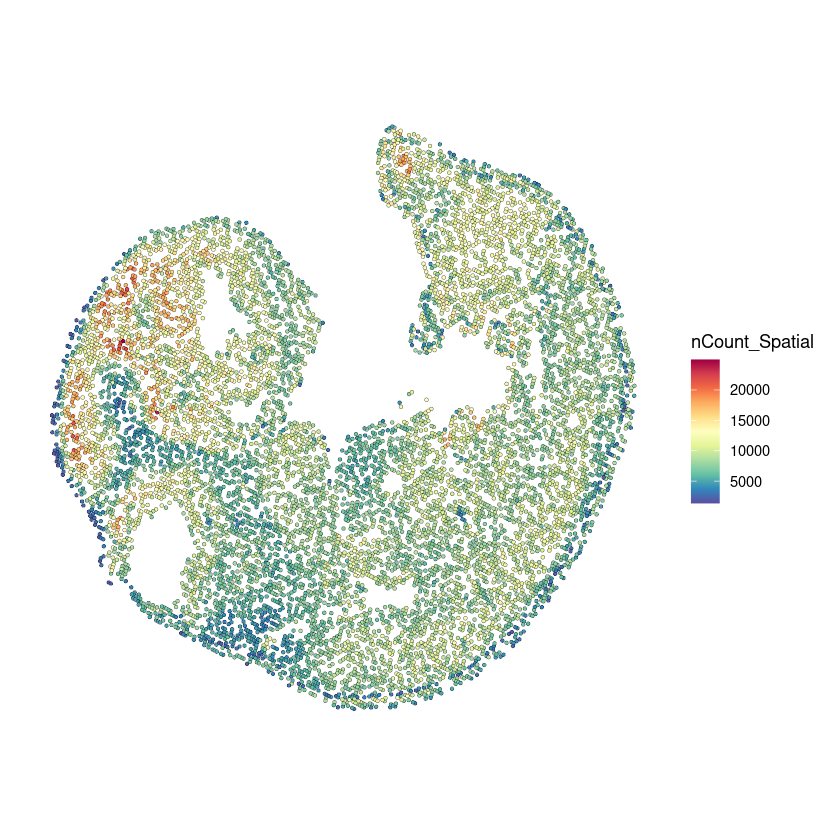

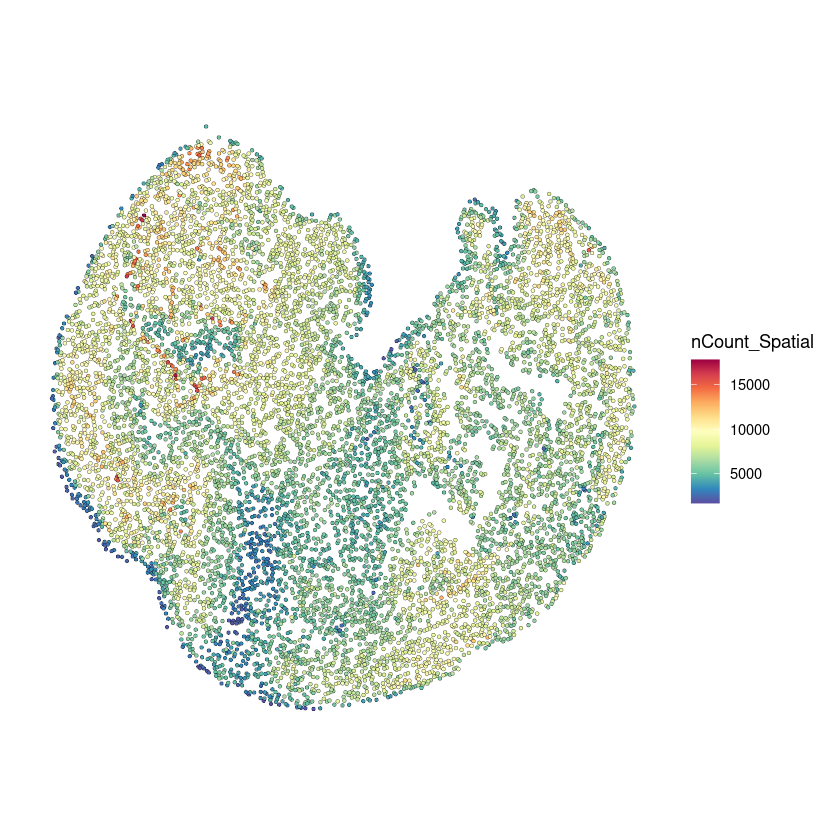

In [17]:
coord.df.1 <- data.frame(x = adata1$obsm$spatial[, 1], y = adata1$obsm$spatial[, 2], stringsAsFactors = FALSE)
rownames(coord.df.1) <- Cells(slide.seq.1)
slide.seq.1@images$image <- new(
    Class = "SlideSeq", # can not change class name
    assay = "Spatial",
    key = "image_",
    coordinates = coord.df.1
  )

coord.df.2 <- data.frame(x = adata2$obsm$spatial[, 1], y = adata2$obsm$spatial[, 2], stringsAsFactors = FALSE)
rownames(coord.df.2) <- Cells(slide.seq.2)
slide.seq.2@images$image <- new(
    Class = "SlideSeq", # can not change class name
    assay = "Spatial",
    key = "image_",
    coordinates = coord.df.2
  )
SpatialFeaturePlot(slide.seq.1, features = "nCount_Spatial") + theme(legend.position = "right")
SpatialFeaturePlot(slide.seq.2, features = "nCount_Spatial") + theme(legend.position = "right")


In [18]:
slide.seq.1@meta.data["batch"] <- "a1"
slide.seq.2@meta.data["batch"] <- "a2"
seu_list <- list(slide.seq.1, slide.seq.2)
seu_list <- lapply(X = seu_list, FUN = function(x) {
    x <- NormalizeData(x) # has been normalized
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2500)
})

# select features that are repeatedly variable across datasets for integration
features <- SelectIntegrationFeatures(object.list = seu_list)

In [19]:
seu.anchors <- FindIntegrationAnchors(object.list = seu_list, anchor.features = features, verbose = FALSE)
seu_combined <- IntegrateData(anchorset = seu.anchors, verbose = FALSE)

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


In [20]:
DefaultAssay(seu_combined) <- "integrated"
seu_combined <- ScaleData(seu_combined, verbose = FALSE)
seu_combined <- RunPCA(seu_combined, npcs = 50, verbose = FALSE)

In [21]:
embd1 <- seu_combined@reductions$pca@cell.embeddings[1:dim(slide.seq.1)[2], ]
embd2 <- seu_combined@reductions$pca@cell.embeddings[-c(1:dim(slide.seq.1)[2]), ]
fwrite(embd1, sep = ",", file = "./seurat_embd0.csv")
fwrite(embd2, sep = ",", file = "./seurat_embd1.csv")

x being coerced from class: matrix to data.table

x being coerced from class: matrix to data.table

